## Load Data From Kaggle

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

## Download Data

In [ ]:
! kaggle datasets download kmader/skin-cancer-mnist-ham10000

100% 5.19G/5.20G [00:51<00:00, 184MB/s]
100% 5.20G/5.20G [00:51<00:00, 108MB/s]


In [ ]:
! kaggle datasets download alexako/unet-weights

 99% 234M/235M [00:04<00:00, 25.3MB/s]
100% 235M/235M [00:05<00:00, 49.1MB/s]


## Extract Dataset

In [ ]:
import zipfile
with zipfile.ZipFile('/content/skin-cancer-mnist-ham10000.zip', 'r') as zip_ref:
    zip_ref.extractall('skin')

In [ ]:
import zipfile
with zipfile.ZipFile('/content/unet-weights.zip', 'r') as zip_ref:
    zip_ref.extractall('unet')

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(42)
import random
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, MaxPool2D, UpSampling2D, Input, Reshape

from tensorflow.keras import backend as K
import itertools
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split


In [ ]:
base_skin_dir = os.path.join('..', '/content/skin')
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [ ]:
skin_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get)
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [ ]:
print(skin_df.columns)

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization',
       'path', 'cell_type', 'cell_type_idx'],
      dtype='object')


In [ ]:
skin_df.head(3)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/skin/HAM10000_images_part_1/ISIC_0027...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/skin/HAM10000_images_part_1/ISIC_0025...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/skin/HAM10000_images_part_1/ISIC_0026...,Benign keratosis-like lesions,2


**Data Cleaning**

In [ ]:
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)
print(skin_df.dtypes)

lesion_id         object
image_id          object
dx                object
dx_type           object
age              float64
sex               object
localization      object
path              object
cell_type         object
cell_type_idx       int8
dtype: object


**Distrubtion of the 7 different classes**

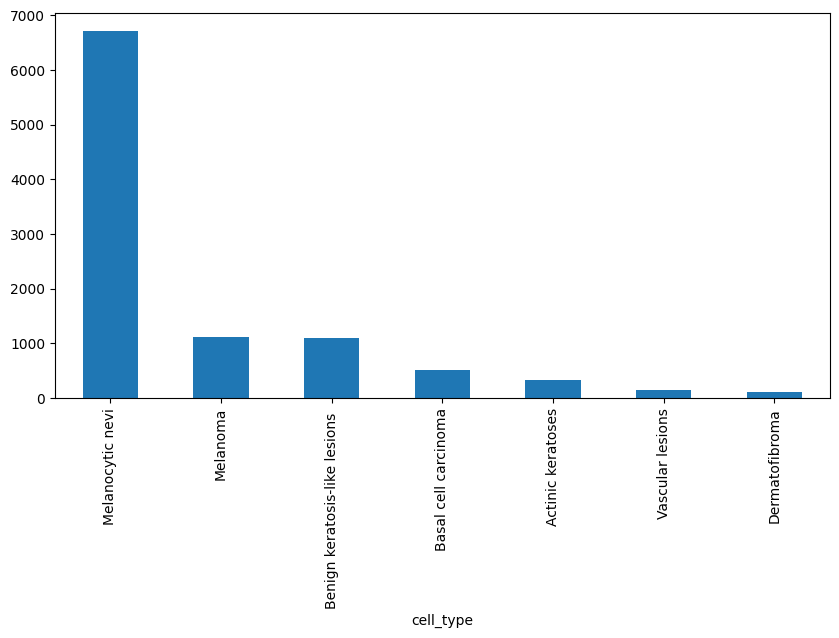

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

# Save the plot as a PNG file
plt.savefig('Cell_Type_Counts.png')

plt.show()


**Apply Downsampling due to imbalance dataset**

In [ ]:
from sklearn.utils import resample

samples_count = skin_df['cell_type'].value_counts()
majority_class = skin_df['cell_type'].isin([samples_count.idxmax()])
minority_class = skin_df['cell_type'].isin([samples_count.idxmin()])

df_majority = skin_df[majority_class]
df_minority = skin_df[minority_class]

print(skin_df['cell_type'].value_counts().idxmax())

Melanocytic nevi


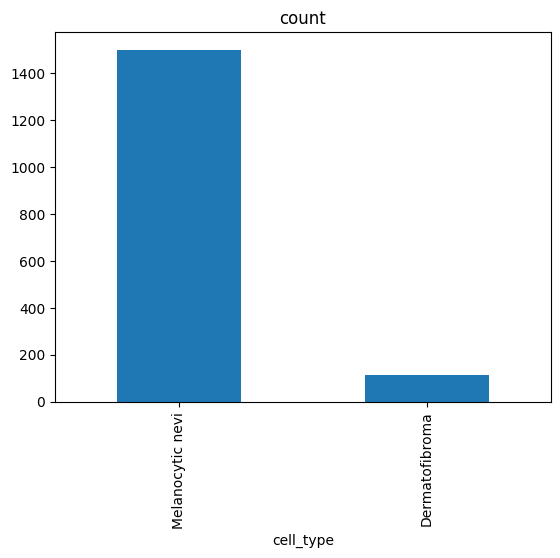

In [ ]:
# Downsample majority class
df_majority_downsampled = resample(df_majority,
                                 replace=False,     # sample without replacement
                                 n_samples=1500,    # to match minority class
                                 random_state=123)  # reproducible results
# Combine majority class with downsampled minority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# Display new class counts
df_downsampled['cell_type'].value_counts().plot(kind='bar', title='count')

# Save the plot as a PNG file
plt.savefig('class_counts_downsamling.png')


**Upsampling**

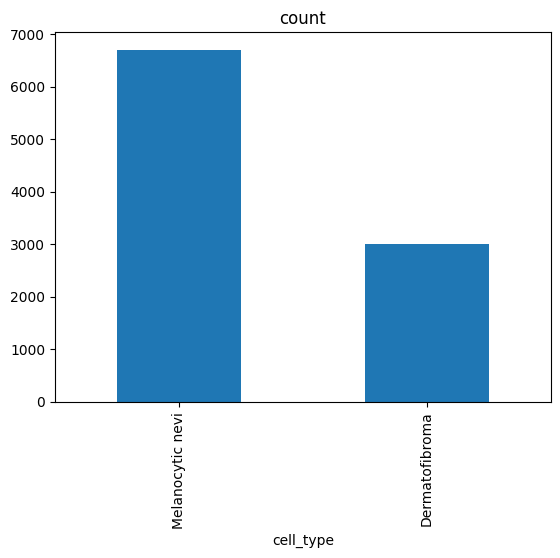

In [ ]:
# Upsample minority class
df_minority_upsampled = resample(df_minority,
                                 replace=True,      # sample with replacement
                                 n_samples=3000,    # to match majority class
                                 random_state=42)   # reproducible results

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Display new class counts
df_upsampled['cell_type'].value_counts().plot(kind='bar', title='count')
# Save the plot as a PNG file
plt.savefig('class_counts_upsampling.png')

cell_type
Melanocytic nevi                  1500
Melanoma                          1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: count, dtype: int64


<function matplotlib.pyplot.show(close=None, block=None)>

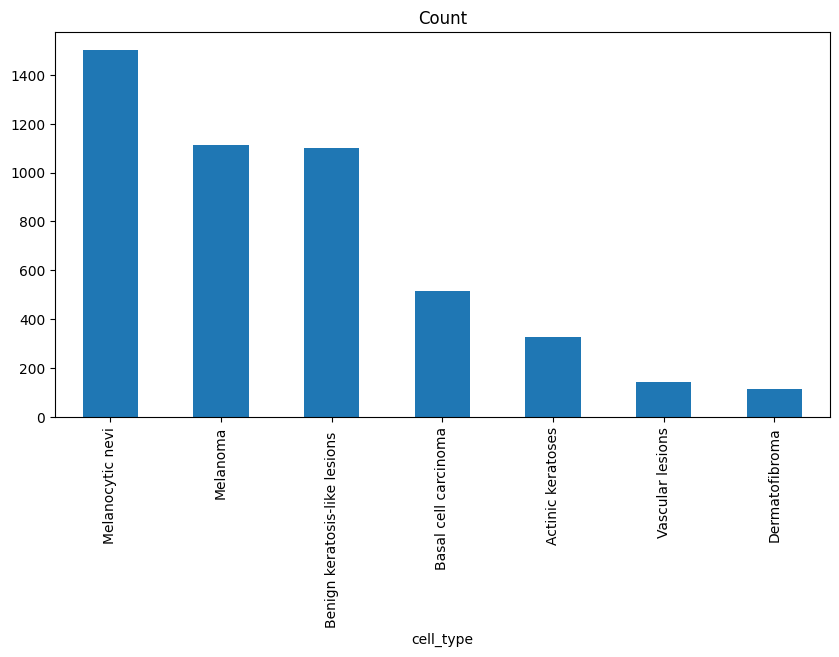

In [ ]:
skin_df = skin_df[skin_df['cell_type'] != skin_df['cell_type'].value_counts().idxmax()]
skin_df = pd.concat([skin_df, df_majority_downsampled], sort=True)

# Calculate the counts of each cell type
counts = skin_df['cell_type'].value_counts()

# Plot the counts on a bar chart
plt.figure(figsize=(10, 5))
counts.plot(kind='bar', title='Count')

# Save the plot as a PNG file
plt.savefig('cell_type_counts_resample_dataset.png')
print(skin_df['cell_type'].value_counts())
plt.show

<Axes: xlabel='dx_type'>

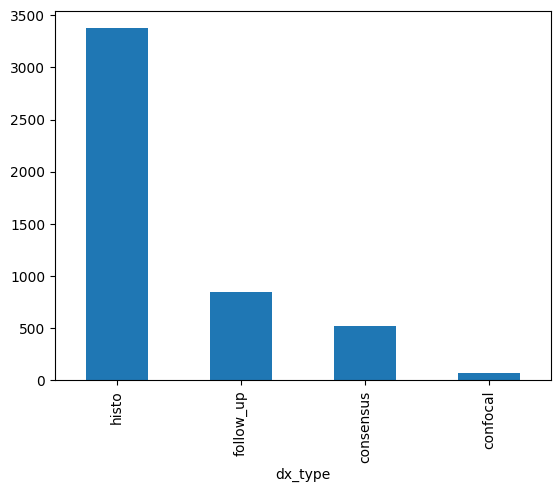

In [ ]:
skin_df['dx_type'].value_counts().plot(kind='bar')

**Distribution of localized field**

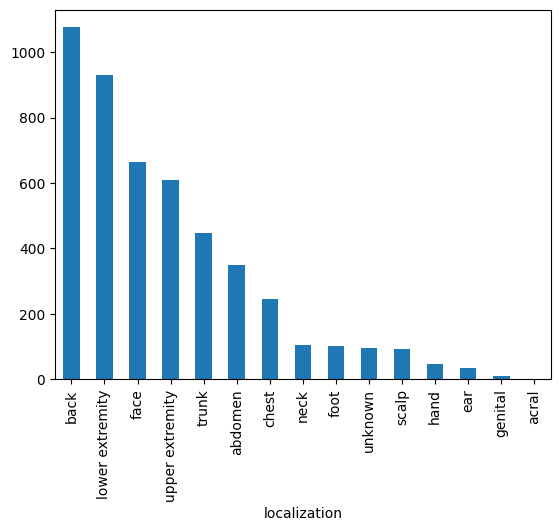

In [ ]:
skin_df['localization'].value_counts().plot(kind='bar')
plt.savefig('localization.png')

**Distribution of age**

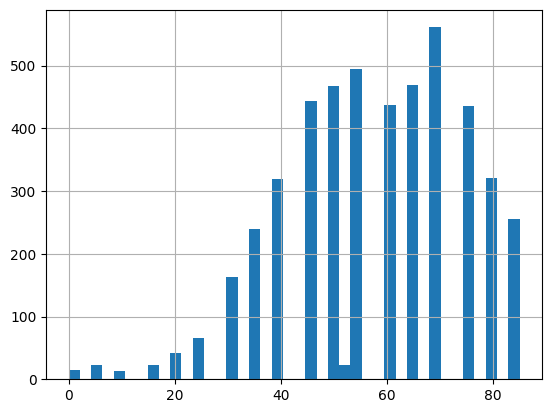

In [ ]:
skin_df['age'].hist(bins=40)
plt.savefig('Distribution of Age')

**Distribution of Gender**

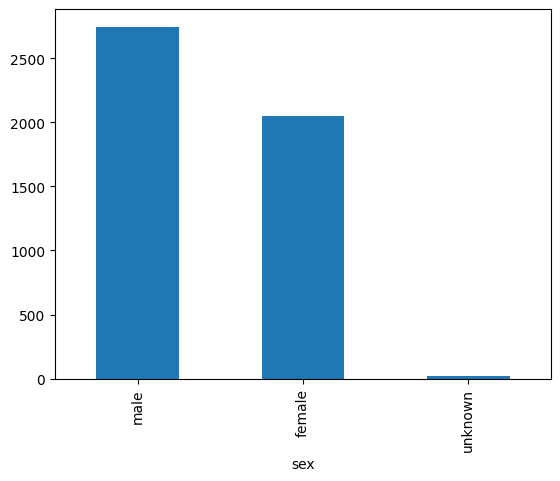

In [ ]:
skin_df['sex'].value_counts().plot(kind='bar')
plt.savefig('Distribution_of_gender.png')

**Distribution of age and cancer type**

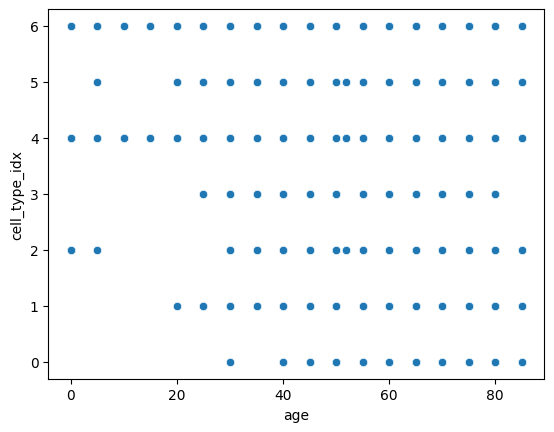

In [ ]:
sns.scatterplot(x='age', y='cell_type_idx', data=skin_df)
plt.savefig('distribution_age_cancer_type.png')

**Resize the images**

In [ ]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((128,96))))

**Display sample images of each cancer type**

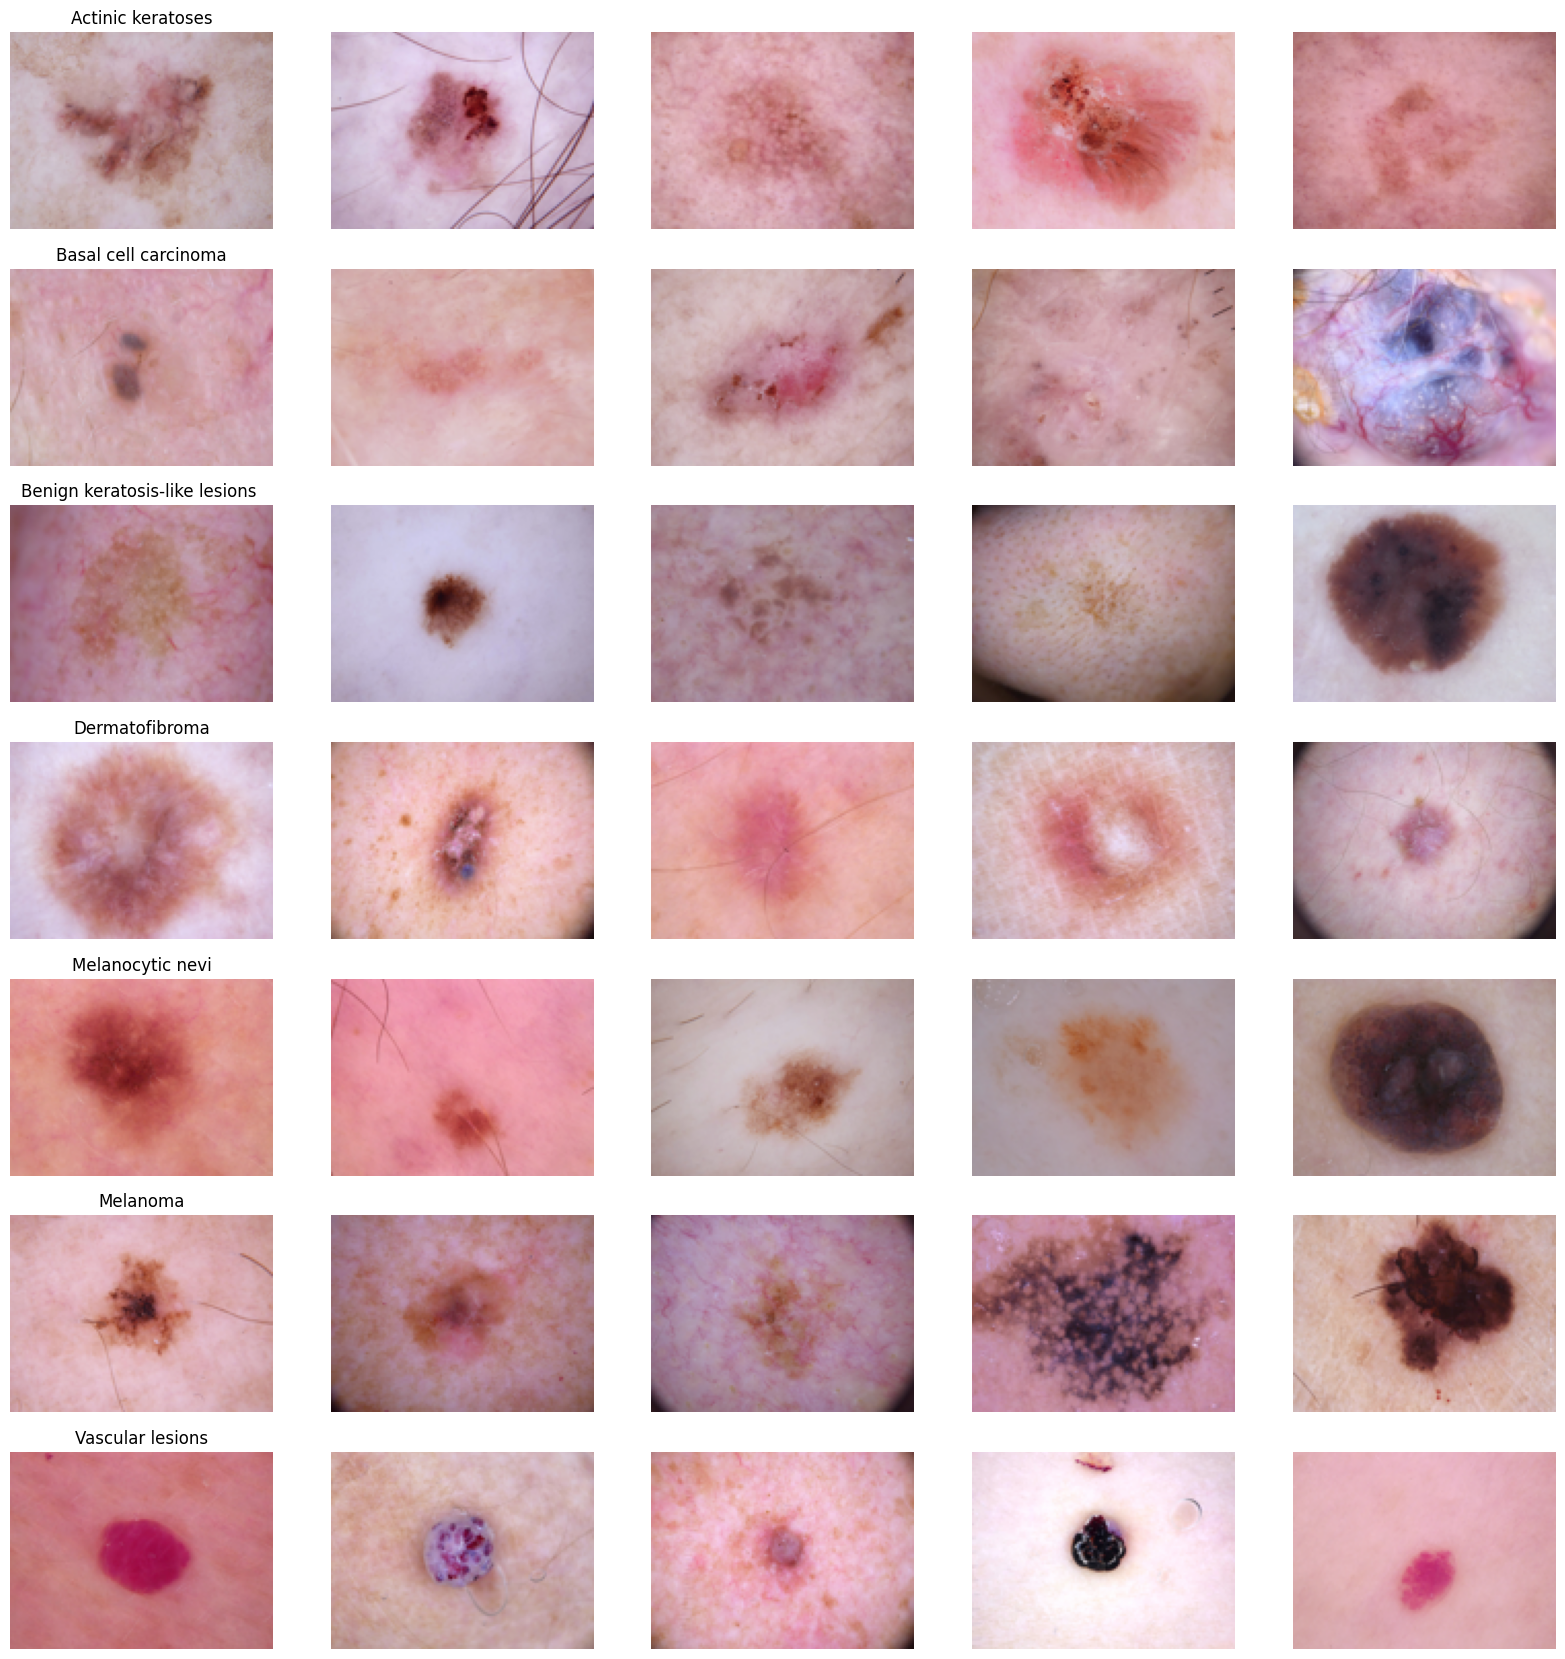

In [ ]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs,
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [ ]:
skin_df['image'].map(lambda x: x.shape).value_counts()

image
(96, 128, 3)    4810
Name: count, dtype: int64

**set target and features**

In [ ]:
features = skin_df.drop(columns=['cell_type_idx'],axis=1)
target = skin_df['cell_type_idx']

**Split training set**

In [ ]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.10,random_state=1234)

**Normalization**

In [ ]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

**Label encoding**

In [ ]:
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

**Spliting traning and validation**

In [ ]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

**Reshape images into 3 dimension**

In [ ]:
x_train = x_train.reshape(x_train.shape[0], *(96, 128, 3))
x_test = x_test.reshape(x_test.shape[0], *(96, 128, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(96, 128, 3))

In [ ]:
print(np.bincount(skin_df['cell_type_idx']))

[ 327  514 1099  115 1500 1113  142]


**Load U-Net model**

In [ ]:
def unet():
    input_shape = (96, 128, 3)
    img_input = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), padding='same', name='conv1',strides= (1,1))(img_input)
    x = BatchNormalization(name='bn1')(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same', name='conv2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(128, (3, 3), padding='same', name='conv3')(x)
    x = BatchNormalization(name='bn3')(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same', name='conv4')(x)
    x = BatchNormalization(name='bn4')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(256, (3, 3), padding='same', name='conv5')(x)
    x = BatchNormalization(name='bn5')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv6')(x)
    x = BatchNormalization(name='bn6')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv7')(x)
    x = BatchNormalization(name='bn7')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(512, (3, 3), padding='same', name='conv8')(x)
    x = BatchNormalization(name='bn8')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv9')(x)
    x = BatchNormalization(name='bn9')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv10')(x)
    x = BatchNormalization(name='bn10')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(512, (3, 3), padding='same', name='conv11')(x)
    x = BatchNormalization(name='bn11')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv12')(x)
    x = BatchNormalization(name='bn12')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv13')(x)
    x = BatchNormalization(name='bn13')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Dense(1024, activation = 'relu', name='fc1')(x)
    x = Dense(1024, activation = 'relu', name='fc2')(x)

    # Decoding Layer
    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv1')(x)
    x = BatchNormalization(name='bn14')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv2')(x)
    x = BatchNormalization(name='bn15')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv3')(x)
    x = BatchNormalization(name='bn16')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv4')(x)
    x = BatchNormalization(name='bn17')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv5')(x)
    x = BatchNormalization(name='bn18')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv6')(x)
    x = BatchNormalization(name='bn19')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv7')(x)
    x = BatchNormalization(name='bn20')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv8')(x)
    x = BatchNormalization(name='bn21')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv9')(x)
    x = BatchNormalization(name='bn22')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv10')(x)
    x = BatchNormalization(name='bn23')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv11')(x)
    x = BatchNormalization(name='bn24')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv12')(x)
    x = BatchNormalization(name='bn25')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv13')(x)
    x = BatchNormalization(name='bn26')(x)
    x = Activation('sigmoid')(x)

    pred = Reshape((96, 128))(x)
    model = Model(inputs=img_input, outputs=pred)
    model.load_weights('/content/unet/unet_100_epoch.h5')

    return model

unet_model = unet()

**Helper method**

In [ ]:
def enhance(img):
    sub = (unet_model.predict(img.reshape(1,96,128,3))).flatten()

    for i in range(len(sub)):
        if sub[i] > 0.5:
            sub[i] = 1
        else:
            sub[i] = 0
    return sub

In [ ]:
import cv2

def applyMask(img):
    mask = np.array(enhance(img).reshape(96, 128), dtype=np.uint8)

    res = cv2.bitwise_and(img,img,mask = mask)

    return res

**Apply mask**

In [ ]:
random_sample_df = skin_df.sample(n=5)
print(random_sample_df['cell_type'].value_counts())

img_list = [img for img in random_sample_df['image']]

seg_img_list = [applyMask(img) for img in img_list]

In [ ]:
def show_comparison(img_list):
    for i in range(len(img_list)):
        plt.figure(figsize=(16,16))
        plt.subplot(i+1,3,1)
        plt.imshow(img_list[i])
        plt.title('Original Image')
        plt.subplot(i+1,3,2)
        plt.imshow(enhance(img_list[i]).reshape(96, 128), plt.cm.binary_r)
        plt.title('Predicted Mask')
        plt.subplot(i+1,3,3)
        plt.imshow(applyMask(img_list[i]), plt.cm.binary_r)
        plt.title('Segmented Image')
        plt.savefig('segmented_images.png')

show_comparison(img_list)

## Create Dataset

In [ ]:
output_base_dir = 'Output'
if not os.path.exists(output_base_dir):
    os.makedirs(output_base_dir)

In [ ]:
def enhance(img_array):
    prediction = unet_model.predict(img_array.reshape(1,96,128,3))
    mask = (prediction.flatten() > 0.5).astype(np.uint8)
    return mask

In [ ]:
def applyMask(img, mask):
    reshaped_mask = mask.reshape(96, 128)
    img_uint8 = img.astype(np.uint8)
    res = cv2.bitwise_and(img_uint8, img_uint8, mask=reshaped_mask)
    return res

In [ ]:
def process_and_save_images(df):
    for index, row in df.iterrows():

        img = row['image']

        mask = enhance(img)

        segmented_img = applyMask(img, mask)

        segmented_img_pil = Image.fromarray(segmented_img)

        cell_type_dir = os.path.join(output_base_dir, row['cell_type'])
        if not os.path.exists(cell_type_dir):
            os.makedirs(cell_type_dir)

        save_path = os.path.join(cell_type_dir, row['image_id'] + '.png')

        segmented_img_pil.save(save_path)

In [ ]:
process_and_save_images(skin_df)

# **Skin Images Classification code**

In [160]:
from vit_keras import vit, utils
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, optimizers, models
import os
from tensorflow.keras.applications.mobilenet import MobileNet
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
import matplotlib.pyplot as plt

In [89]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/Skin Dataset/segmented_images.zip', 'r') as zip_ref:
    zip_ref.extractall("/content/drive/MyDrive/Skin data")

In [161]:
data_path="/content/drive/MyDrive/Skin data"

In [162]:
names=os.listdir(data_path)
names

['Benign keratosis-like lesions ',
 'Dermatofibroma',
 'Melanocytic nevi',
 'Melanoma',
 'Vascular lesions']

In [163]:
count=0
for name in names:
    size=len(os.listdir(os.path.join(data_path, name)))
    count+=size
    print(count, name)

1099 Benign keratosis-like lesions 
1214 Dermatofibroma
2714 Melanocytic nevi
3827 Melanoma
3969 Vascular lesions


In [174]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15,
    # rotation_range=40,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    # fill_mode='nearest',
    # horizontal_flip=True,
    # vertical_flip=True
)

In [175]:
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15
)

In [176]:
train_generator = train_datagen.flow_from_directory(
    data_path,
    target_size=(224,224),
    subset='training',
    batch_size=40
)

validation_generator = val_datagen.flow_from_directory(
    data_path,
    target_size=(224,224),
    subset='validation',
    batch_size=20
)

Found 2781 images belonging to 5 classes.
Found 1188 images belonging to 5 classes.


In [177]:
model = Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal',input_shape=(224,224,3)))
model.add(layers.MaxPooling2D())
model.add(BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(layers.MaxPooling2D())
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(layers.MaxPooling2D())
model.add(layers.BatchNormalization())
model.add(Flatten())
model.add(Dropout(rate=0.5))
model.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(rate=0.5))
model.add(Dense(64, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(rate=0.5))
model.add(Dense(32, activation='relu', kernel_initializer='he_normal', ))
model.add(BatchNormalization())

model.add(Dense(units=5, activation='softmax', kernel_initializer='glorot_uniform', name='classifier'))

In [178]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_66 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 112, 112, 32)      0         
 ng2D)                                                           
                                                                 
 batch_normalization_52 (Ba  (None, 112, 112, 32)      128       
 tchNormalization)                                               
                                                                 
 conv2d_67 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 conv2d_68 (Conv2D)          (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_41 (MaxPooli  (None, 56, 56, 64)      

In [179]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [180]:
history = model.fit(
    train_generator,
    epochs=40,
    validation_data=validation_generator
)

Epoch 1/40
70/70 [==============================] - 27s 308ms/step - loss: 1.9502 - accuracy: 0.2643 - val_loss: 1.7094 - val_accuracy: 0.2811
Epoch 2/40
70/70 [==============================] - 24s 340ms/step - loss: 1.6492 - accuracy: 0.3542 - val_loss: 1.6012 - val_accuracy: 0.3056
Epoch 3/40
70/70 [==============================] - 19s 269ms/step - loss: 1.5176 - accuracy: 0.4017 - val_loss: 1.6231 - val_accuracy: 0.2769
Epoch 4/40
13/70 [====>.........................] - ETA: 12s - loss: 1.4503 - accuracy: 0.3827

KeyboardInterrupt: 

In [155]:
model.save("/content/drive/MyDrive/skin_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


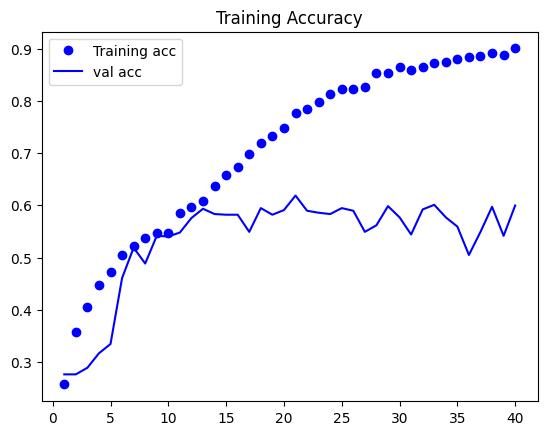

In [156]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='val acc')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

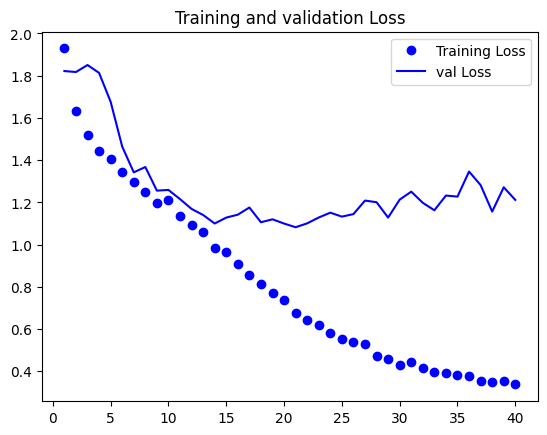

In [157]:
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs= range(1,len(loss)+1)
plt.plot(epochs, loss, 'bo', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="val Loss")
plt.title("Training and validation Loss")
plt.legend()
plt.show()

In [158]:
loss,acc= model.evaluate(validation_generator)

40/40 [==============================] - 4s 89ms/step - loss: 1.2118 - accuracy: 0.5997


In [159]:
print("Test Data Loss: ",loss)
print("Test Data Accuracy: ",acc)

Test Data Loss:  1.211774230003357
Test Data Accuracy:  0.5997474789619446
